Epoch 1/10
469/469 [==============================] - 28s 57ms/step - loss: 0.2862 - reconstruction_loss: 0.2862 - kl_loss: 7.4476e-06 - val_loss: 0.0000e+00
Epoch 2/10
469/469 [==============================] - 27s 57ms/step - loss: 0.2580 - reconstruction_loss: 0.2633 - kl_loss: 5.2220e-08 - val_loss: 0.0000e+00
Epoch 3/10
469/469 [==============================] - 27s 57ms/step - loss: 0.2580 - reconstruction_loss: 0.2631 - kl_loss: 3.8109e-08 - val_loss: 0.0000e+00
Epoch 4/10
469/469 [==============================] - 27s 58ms/step - loss: 0.2531 - reconstruction_loss: 0.2630 - kl_loss: 2.3969e-08 - val_loss: 0.0000e+00
Epoch 5/10
469/469 [==============================] - 27s 57ms/step - loss: 0.2612 - reconstruction_loss: 0.2631 - kl_loss: 5.8558e-08 - val_loss: 0.0000e+00
Epoch 6/10
469/469 [==============================] - 27s 58ms/step - loss: 0.2670 - reconstruction_loss: 0.2631 - kl_loss: 3.5097e-08 - val_loss: 0.0000e+00
Epoch 7/10
469/469 [==============================] 

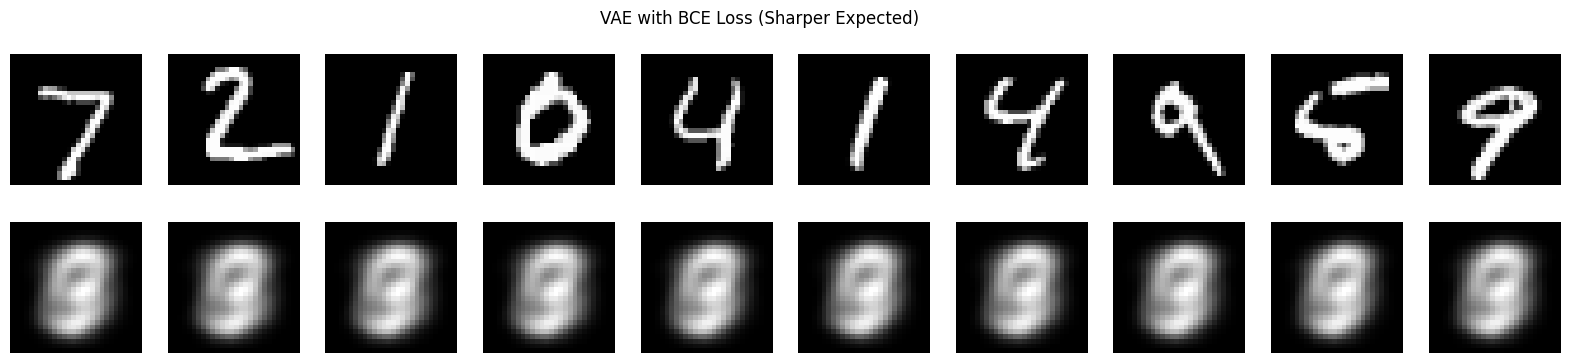

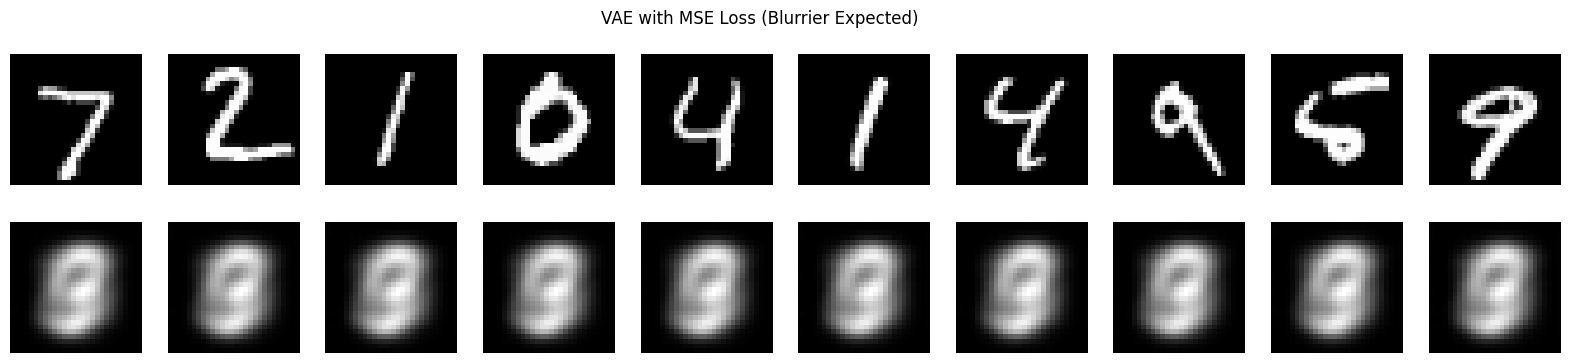

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
import matplotlib.pyplot as plt

# ========== Data Loading ============
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = x_train[..., None]
x_test  = x_test[..., None]

# ========== Hyperparameters ==========
LATENT_DIM = 2
EPOCHS     = 10
BATCH_SIZE = 128

# ========== Encoder ============
def build_encoder(latent_dim):
    inp = layers.Input((28,28,1))
    x   = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inp)
    x   = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x   = layers.Flatten()(x)
    x   = layers.Dense(16, activation="relu")(x)
    z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return Model(inp, [z_mean, z_log_var], name="encoder")

# ========== Sampling Layer ============
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

# ========== Decoder (sigmoid output for both) ============
def build_decoder(latent_dim):
    inp = layers.Input((latent_dim,))
    x   = layers.Dense(7*7*64, activation="relu")(inp)
    x   = layers.Reshape((7,7,64))(x)
    x   = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x   = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    out = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
    return Model(inp, out, name="decoder")

# ========== VAE Class ============
class VAE(Model):
    def __init__(self, encoder, decoder, loss_fn):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.loss_fn  = loss_fn

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        return self.decoder(z)

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x)
            z = self.sampling((z_mean, z_log_var))
            x_recon = self.decoder(z)

            recon_loss = tf.reduce_mean(self.loss_fn(x, x_recon))
            kl_loss    = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss
        }

# ========== Build & Compile VAEs ============

# 1) BCE VAE
enc_bce = build_encoder(LATENT_DIM)
dec_bce = build_decoder(LATENT_DIM)
vae_bce = VAE(enc_bce, dec_bce, loss_fn=losses.BinaryCrossentropy())
vae_bce.compile(optimizer="adam")

# 2) MSE VAE
enc_mse = build_encoder(LATENT_DIM)
dec_mse = build_decoder(LATENT_DIM)
vae_mse = VAE(enc_mse, dec_mse, loss_fn=losses.MeanSquaredError())
vae_mse.compile(optimizer="adam")

# ========== Train ============
history_bce = vae_bce.fit(
    x_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(x_test, None), verbose=1
)
history_mse = vae_mse.fit(
    x_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(x_test, None), verbose=1
)

# ========== Visualize Reconstructions ============
def show_reconstructions(model, title):
    originals = x_test[:10]
    z_mean, z_log_var = model.encoder(originals)
    z = model.sampling((z_mean, z_log_var))
    reconstructions = model.decoder(z).numpy()

    plt.figure(figsize=(20,4))
    for i in range(10):
        # Original
        ax = plt.subplot(2, 10, i+1)
        plt.imshow(originals[i].squeeze(), cmap='gray')
        ax.axis('off')
        # Reconstruction
        ax = plt.subplot(2, 10, i+1+10)
        plt.imshow(reconstructions[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

show_reconstructions(vae_bce, "VAE with BCE Loss (Sharper Expected)")
show_reconstructions(vae_mse, "VAE with MSE Loss (Blurrier Expected)")
